In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import bz2
import urllib
import seaborn as sns
import networkx as nx
import statsmodels.api as sm
import statsmodels.formula.api as smf
#pip install nltk
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
%matplotlib inline
data_folder = 'data/'

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/arthurdietrich/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [114]:
#pip install pyarrow
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [115]:
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

In [116]:
def matching(df):
    # Separate the treatment and control groups
    treatment_df = df[df['party_Democratic'] == 1]
    control_df = df[df['party_Democratic'] == 0]

    # Create an empty undirected graph
    G = nx.Graph()

    # Loop through all the pairs of instances
    for control_id, control_row in control_df.iterrows():
        for treatment_id, treatment_row in treatment_df.iterrows():

            # Calculate the similarity 
            similarity = get_similarity(control_row['Propensity_score'],
                                        treatment_row['Propensity_score'])
            if (similarity > 0.75):

            # Add an edge between the two instances weighted by the similarity between them
                G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

    # Generate and return the maximum weight matching on the generated graph
    matching = nx.max_weight_matching(G)
    matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
    balanced_df = df.iloc[matched]
    return balanced_df

In [117]:
def logreg(df):
    df = pd.get_dummies(df,columns = ['gender','party'])
    df['age'] = (df['age'] - df['age'].mean())/df['age'].std()
    
    mod = smf.logit(formula='party_Democratic ~  C(gender_female) + age', data=df)

    res = mod.fit()

    # Extract the estimated propensity scores
    df['Propensity_score'] = res.predict()
    print(res.summary())

    return df

In [118]:
def clean_df(df):
    df = df[df['party'].notna()].copy()#supp les None
    df = df[df['age'].notna()].copy() #supp les None
    
    df.party = df.party.str[0] # on garde que le premier parti politique         
        
    print(df['party'].value_counts()) #--> permet de voir les occurences de chaque parti : 
                                      # bcp plus de Republicains et Démocrates = on néglige le reste
        
    df.party.loc[df['party'].str.contains('Democratic')] = 'Democratic'
    df.party.loc[df['party'].str.contains('Republican')] = 'Republican'
    df = df.loc[(df['party'].str.contains('Democratic')) | \
                df['party'].str.contains('Republican')].copy() #uniquement Dem et Rep
    
    df = df.reset_index()
    return df

In [119]:
def sentiment_analysis(df):
    sid = SentimentIntensityAnalyzer()
    df['sentiment'] = df.quotation.apply(sid.polarity_scores)
    df['sentiment'] = df.sentiment.apply(dict.values)
    df['sentiment'] = df.sentiment.apply(list)
    df['sentiment'] = df.sentiment.str[-1]
    return df

In [120]:
def process_chunk(chunk):
    print(f'Processing chunk with {len(chunk)} rows')
    df = chunk.copy()
    df = clean_df(df)
    df = logreg(df)
    balanced_df = matching(df)
    balanced_df = sentiment_analysis(balanced_df)
    
    return balanced_df, df

In [137]:
with pd.read_json(data_folder + 'quotes-2017-extended.json.bz2', lines=True, compression='bz2', chunksize=2000) as df_reader:
    iter_ = 0
    for chunk in df_reader:
        iter_ +=1 
        [balanced_df, df] = process_chunk(chunk)
        if iter_ > 0:
            break

Processing chunk with 2000 rows
Republican Party                                410
Democratic Party                                353
Minnesota Democratic–Farmer–Labor Party           6
Conservative Party of New York State              4
Liberty Union Party                               4
Conservative Party                                3
Peace and Freedom Party                           3
Republican Party of Arkansas                      3
independent politician                            3
Labour Party                                      2
California Democratic Party                       2
Republican Party of Minnesota                     2
California Republican Party                       2
Nebraska Democratic Party                         1
Republican Party of Iowa                          1
People's Party for Freedom and Democracy          1
Liberal Party of Canada                           1
Independence Party of Minnesota                   1
Michigan Republican Party       

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value i

Text(0.5, 0, 'group')

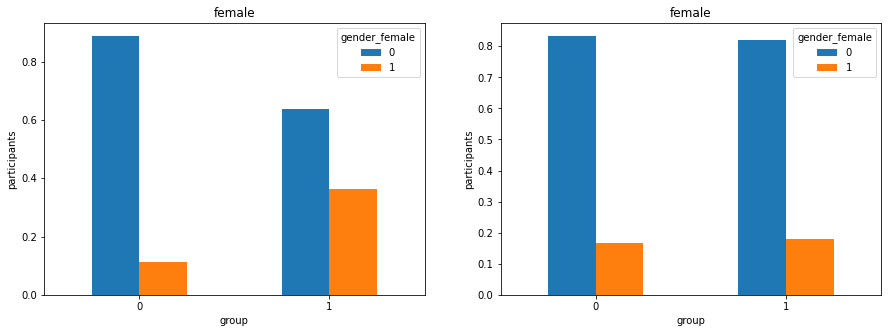

In [138]:
fig, (ax1, ax2) = plt.subplots(1, 2)
group = df.groupby(['party_Democratic', 'gender_female'])['gender_female'].count()
group = group.unstack()
group = group.div(group.sum(axis=1), axis=0)
pl = group.plot(kind='bar', figsize=[15,5], rot=0, ax = ax1)
pl.set_title('female')
pl.set_ylabel('participants')
pl.set_xlabel('group')

group = balanced_df.groupby(['party_Democratic', 'gender_female'])['gender_female'].count()
group = group.unstack()
group = group.div(group.sum(axis=1), axis=0)
pl = group.plot(kind='bar', figsize=[15,5], rot=0, ax = ax2)
pl.set_title('female')
pl.set_ylabel('participants')
pl.set_xlabel('group')

In [123]:
display(balanced_df)

,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,...,occupation,age,ethnic_group,religion,gender_female,gender_male,party_Democratic,party_Republican,Propensity_score,sentiment
73,204,2017-06-09-104537,"The fastest cure for every social ill, from gu...",Darrell L. Clarke,[Q5224664],2017-06-09 04:00:00,1,"[[Darrell L. Clarke, 0.7825], [None, 0.2175]]",[http://www.phillytrib.com/news/city-oic-team-...,E,...,[politician],1.431652,None,None,0,1,1,0,0.370959,-0.7184
3,9,2017-03-14-098444,"They ask for money. I said, `I don't have any ...",Kim Kardashian,[Q186304],2017-03-14 19:40:45,1,"[[Kim Kardashian, 0.8586], [None, 0.1414]]",[http://feeds.inquisitr.com/~r/google/yDYq/~3/...,E,...,"[fashion designer, socialite, model, blogger, ...",-1.823828,"[Armenian American, Dutch American, English Am...",[Christianity],1,0,1,0,0.732495,-0.1531
352,904,2017-10-09-067210,It's not the firearm that's the problem; it's ...,Ira Hansen,[Q6066080],2017-10-09 21:20:36,1,"[[Ira Hansen, 0.8686], [None, 0.1314]]",[http://mynews4.com/news/local/democratic-legi...,E,...,[politician],-0.196088,None,None,0,1,0,1,0.381976,-0.4019
196,496,2017-11-14-127555,This is not normal. Terrifying scenes of viole...,Gabrielle Giffords,[Q193703],2017-11-14 08:00:00,1,"[[Gabrielle Giffords, 0.6179], [None, 0.3821]]",[http://www.chicoer.com/general-news/20171114/...,E,...,"[politician, businessperson, entrepreneur, ana...",-1.009958,None,[Judaism],1,0,1,0,0.727871,-0.8403
264,660,2017-05-25-049991,If you are a young individual who wants to be ...,Gov. John Bel Edwards,[Q6221385],2017-05-25 18:20:47,1,"[[Gov. John Bel Edwards, 0.8247], [None, 0.166...",[http://www.slate.com/articles/news_and_politi...,E,...,"[lawyer, politician]",-0.684410,None,None,0,1,1,0,0.385306,0.2716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,865,2017-06-11-029315,I'll shoot you if you try and come at me with ...,Aaron Carter,[Q301818],2017-06-11 16:19:18,1,"[[Aaron Carter, 0.9235], [None, 0.067], [Justi...",[http://www.billboard.com/node/7825765],E,...,"[actor, singer-songwriter, singer, television ...",-2.474924,None,None,0,1,0,1,0.397604,0.0258
101,270,2017-05-24-030563,"He's been killed, and apparently nothing serio...",Newt Gingrich,[Q182788],2017-05-24 00:26:18,2,"[[Newt Gingrich, 0.7969], [None, 0.1802], [Set...",[http://www.wnd.com/2017/05/big-list-of-people...,E,...,"[politician, novelist, writer, teacher, histor...",1.187491,None,[Catholicism],0,1,0,1,0.372603,-0.8744
232,585,2017-12-06-154676,"We felt that we had evidence of a murder case,",George Gascon,[Q5539636],2017-12-06 01:35:00,2,"[[George Gascon, 0.6783], [None, 0.3218]]",[http://pleasantonweekly.com/news/2017/12/05/d...,E,...,[lawyer],0.292234,None,None,0,1,1,0,0.378658,-0.6908
342,866,2017-10-26-068500,"I'm no stranger to gun violence here,",John Linder,"[Q1626247, Q6244868]",2017-10-26 04:00:00,1,"[[John Linder, 0.4131], [None, 0.3767], [Dave ...",[http://www.delcotimes.com/general-news/201710...,E,...,"[politician, military officer, dentist, presid...",1.268878,None,None,0,1,0,1,0.372055,-0.8271


count    282.000000
mean      -0.308460
std        0.516356
min       -0.982000
25%       -0.763825
50%       -0.389700
75%        0.025800
max        0.903200
Name: sentiment, dtype: float64 count    282.000000
mean      -0.233701
std        0.541553
min       -0.992800
25%       -0.714575
50%       -0.298200
75%        0.153100
max        0.913600
Name: sentiment, dtype: float64


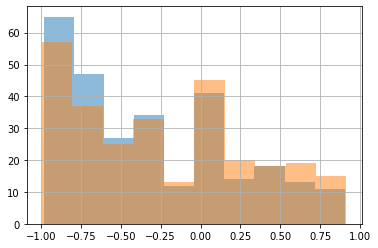

In [149]:
rep_sent = balanced_df.sentiment[df['party_Democratic']==0]
dem_sent = balanced_df.sentiment[df['party_Democratic']==1]
dem_sent.hist(alpha = 0.5)
rep_sent.hist(alpha = 0.5)
print(dem_sent.describe(),rep_sent.describe())

